<a href="https://colab.research.google.com/github/DennisChangach/Geospatial-Analysis/blob/main/Satellite_Imagery_Access_%26_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Satellite Imagery Access & Analysis

The vast amount of satellite imagery collected every day across the globe is huge. Frequent Global coverage of the Earth and high-resolution data with readily available data to the public makes it helpful in monitoring the earth and its environment.

Satellite images are pixel wised data just like any other types of images you have used. In Geography and Remote sensing terminology, this is called Rasters. Raster images mainly consist of satellite images, Lidar data as well as Georeferenced maps. As we will see, rasters consist of a matrix of cells and rows and each cell/row holds information about the location, such as elevation, temperature and vegetation.

**The objectives of this notebook are:**

1. Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
2. Read and Write Raster images in Python.
3. Create RGB and NDVI images from Sentinel 2 Bands

Acknowlegments: -https://github.com/shakasom/rs-python-tutorials/blob/91d92fa88d528f036efc97ae926b199d068431d0/RS_Python.ipynb

### Accessing Data

We will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [4]:
#installing neccessary dependencies
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes

     |████████████████████████████████| 18.3MB 1.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubu

In [5]:
#importing the necessary dependencies
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Before we are able to use sentinelsat, we need to register a username in Copernicus Open Access Hub and note down your username and password and paste them here inside the code.

In [12]:
user = 'dennis_changach' 
password = '0728480518' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In this Notebook, we will use boundary data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which we will use as a boundary to clip from the whole satellite image tile. The boundary of the reserve is in the form of a shapefile which we'll read with Geopandas and visualize it with Folium Library.

In [6]:
# getting the shape file

!wget https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip

--2020-11-02 06:45:06--  https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ymxuxpcnj88mlz2/NReserve.zip [following]
--2020-11-02 06:45:06--  https://www.dropbox.com/s/raw/ymxuxpcnj88mlz2/NReserve.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f7d453851de33ba64f814e8de.dl.dropboxusercontent.com/cd/0/inline/BCbRn29DzPfIrVfJ8HVTeemkQE_Y2w3v5nreGHjcdR3c5izhVg8xCBaFXxVE-W3HTmwe1EnP5E4MXRLMkbyrElyOSlJaM7mgAkPLmxa0oLuvwg/file# [following]
--2020-11-02 06:45:06--  https://uc1f7d453851de33ba64f814e8de.dl.dropboxusercontent.com/cd/0/inline/BCbRn29DzPfIrVfJ8HVTeemkQE_Y2w3v5nreGHjcdR3c5izhVg8xCBaFXxVE-W3HTmwe1EnP5E4MXRLMkbyrElyOSlJaM7mgAkPLmxa0oLuvwg/file
Resolving uc1f7d

In [7]:
#unzipping the file
!unzip 'NReserve.zip'

Archive:  NReserve.zip
   creating: NReserve/
 extracting: NReserve/NaturalReserve_Polygon.cpg  
  inflating: NReserve/NaturalReserve_Polygon.dbf  
  inflating: NReserve/NaturalReserve_Polygon.prj  
  inflating: NReserve/NaturalReserve_Polygon.qpj  
  inflating: NReserve/NaturalReserve_Polygon.shp  
  inflating: NReserve/NaturalReserve_Polygon.shx  


In [8]:
# reading the shapefile
nReserve = gpd.read_file('NReserve/NaturalReserve_Polygon.shp')
nReserve

id                                           geometry
0  None  POLYGON ((12.34697 41.70233, 12.37470 41.71808...

In [9]:
#visualizing using folium
m = folium.Map([41.7023292727353, 12.34697305914639], zoom_start=11)

folium.GeoJson(nReserve).add_to(m)
m

With the above code, we have read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, we can add the Geopandas data to the base map we have created to visualize the Natural Reserve boundary we are interested in. 

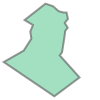

In [10]:
#creating a footprint from the nReserve.geometry
footprint = None
for i in nReserve['geometry']:
    footprint = i
    
footprint

Now we can ran a querry on the api we had created earlier. There are different ways one can construct a querry depending on the use case. In this section, we will query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint-our area of study. 

In [13]:
#API Query
products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [15]:
#products

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but you can tweak the query for your use case example expanding the time period or increasing the cloud coverage percentage.  

In [16]:
# getting the number of images
len(products)

6

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [17]:
#creating a geodataFrame
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


title  ...                                           geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...
590a4ce9-c540-4cb9-844b-3ee1efff8ca9  S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
d1a70889-1d44-414c-a357-08a7185c04b4  S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8  S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
c9e76145-3270-458c-9927-49d1354be29e  S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...  ...  MULTIPOLYGON (((12.70556 41.40403, 12.76314 42...
3155fa67-c0d6-4c0f-a556-f5e0ee532c9d  S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_2...  ...  MULTIPOLYGON (((11.41073 41.40773, 12.72303 41...

[6 rows x 35 columns]

We are interested in the first satellite image since this has the least cloud covergae of all available images. We can simply call download and provide the product name (Note that you can download all images at once with api.download_all() function).

In [18]:
api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

Downloading: 100%|██████████| 1.06G/1.06G [01:32<00:00, 11.5MB/s]
MD5 checksumming: 100%|██████████| 1.06G/1.06G [00:02<00:00, 423MB/s]


{'Creation Date': datetime.datetime(2019, 6, 5, 21, 55, 17, 343000),
 'Ingestion Date': datetime.datetime(2019, 6, 5, 21, 54, 46, 895000),
 'Online': True,
 'date': datetime.datetime(2019, 6, 5, 10, 0, 39, 24000),
 'downloaded_bytes': 1055191497,
 'footprint': 'POLYGON((11.354954233772318 42.39470139413761,12.687592758603905 42.42936087235922,12.723033432665233 41.441212166985935,11.410731332148327 41.407726190110715,11.354954233772318 42.39470139413761))',
 'id': '16e95baf-bbcb-43fe-ab67-5fecea2ffde5',
 'md5': 'ce4fbc92040e79591c7380f7b159b5c3',
 'path': './S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip',
 'size': 1055191497,
 'title': 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('16e95baf-bbcb-43fe-ab67-5fecea2ffde5')/$value"}

### Exploring Satellite Imagery with Rasterio

Once we unzip the downloaded folder, we get many subfolders and it is sometimes hard to navigate through these folders. Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. While there are other higher resolution satellites available(1m to 0.5 cm), Sentinel-2 data is free and has a high revisit time (5 days) which makes it an excellent option to study environmental challenges.

**Creating RGB Image**

The true colour of satellite images is often displayed in a combination of red, green and blue band. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.


In [21]:
#unzipping the file
!unzip S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip 

Archive:  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/INSPIRE.xml  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/star_bg.jpg  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/banner_1.png  


In [22]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'

b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2') #Red
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2') #Green
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2') #Blue

In [23]:
#checking the red colors
b4.count, b4.width,b4.height

(1, 10980, 10980)

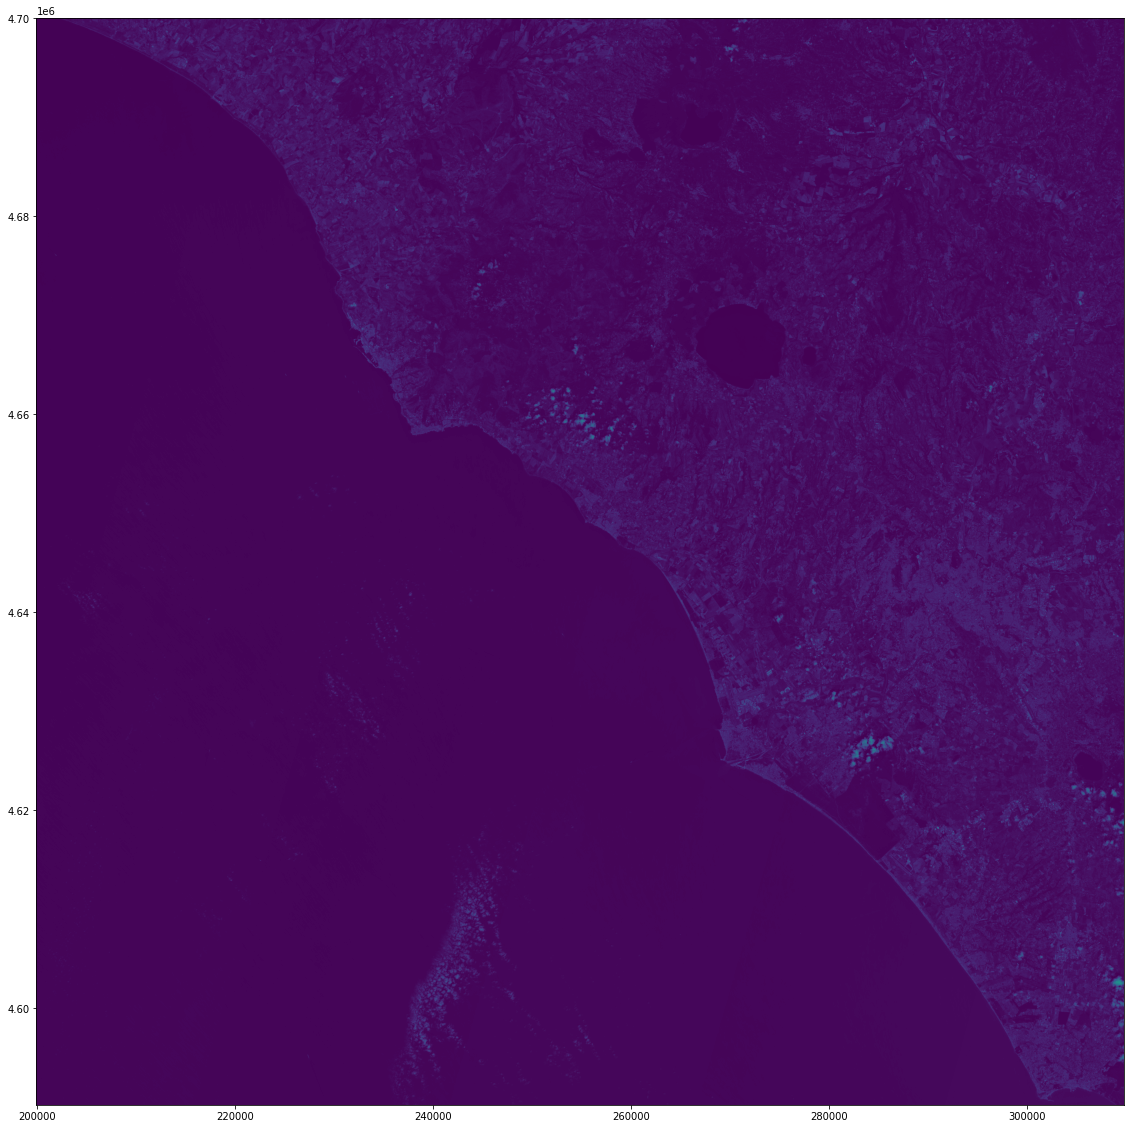

In [24]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

First, we open an empty RGB.tiff in Rasterio with the same parameters — i.e. width, height, CRS, etc.. — of Band 4 ( You can choose any of the three bands). Then we need to write those bands to the empty RGB image.

In [25]:
# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

<function matplotlib.pyplot.show>

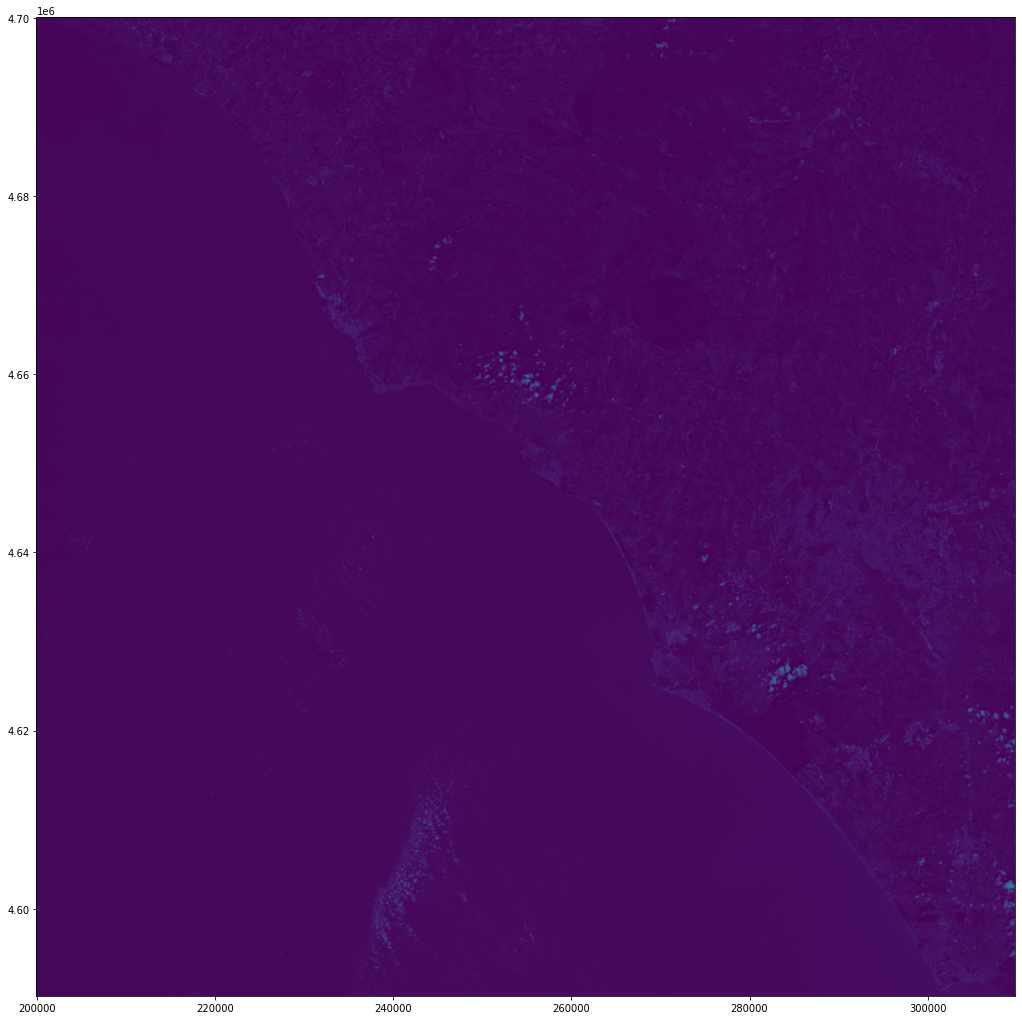

In [36]:
msk = rio.open("RGB.tiff")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk,ax=ax)
plt.show

**Clip/Mask Satellite Images**

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Natural reserve area from the RGB image.

In [26]:
# Reprojecting the Natural reserve to the same projection as the original image
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

#opening the RGB Image to get the metadata
with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


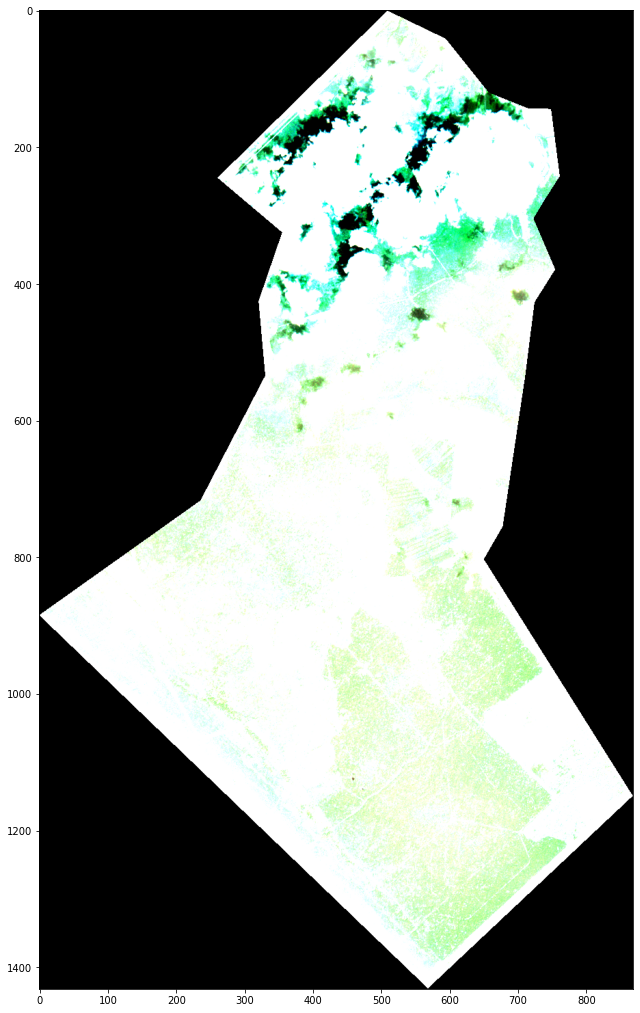

<function matplotlib.pyplot.show>

In [27]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

**Creating NDVI**

Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

nir - red /(nir + red)

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.


In [29]:
# reading the 4th and 8th band
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b8 = rio.open(R10+'/T33TTG_20190605T100039_B08_10m.jp2')

#assigning red and nir to the bands
red = b4.read()
nir = b8.read()

In [30]:
#calculating the NDVI
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

In [31]:
# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

<function matplotlib.pyplot.show>

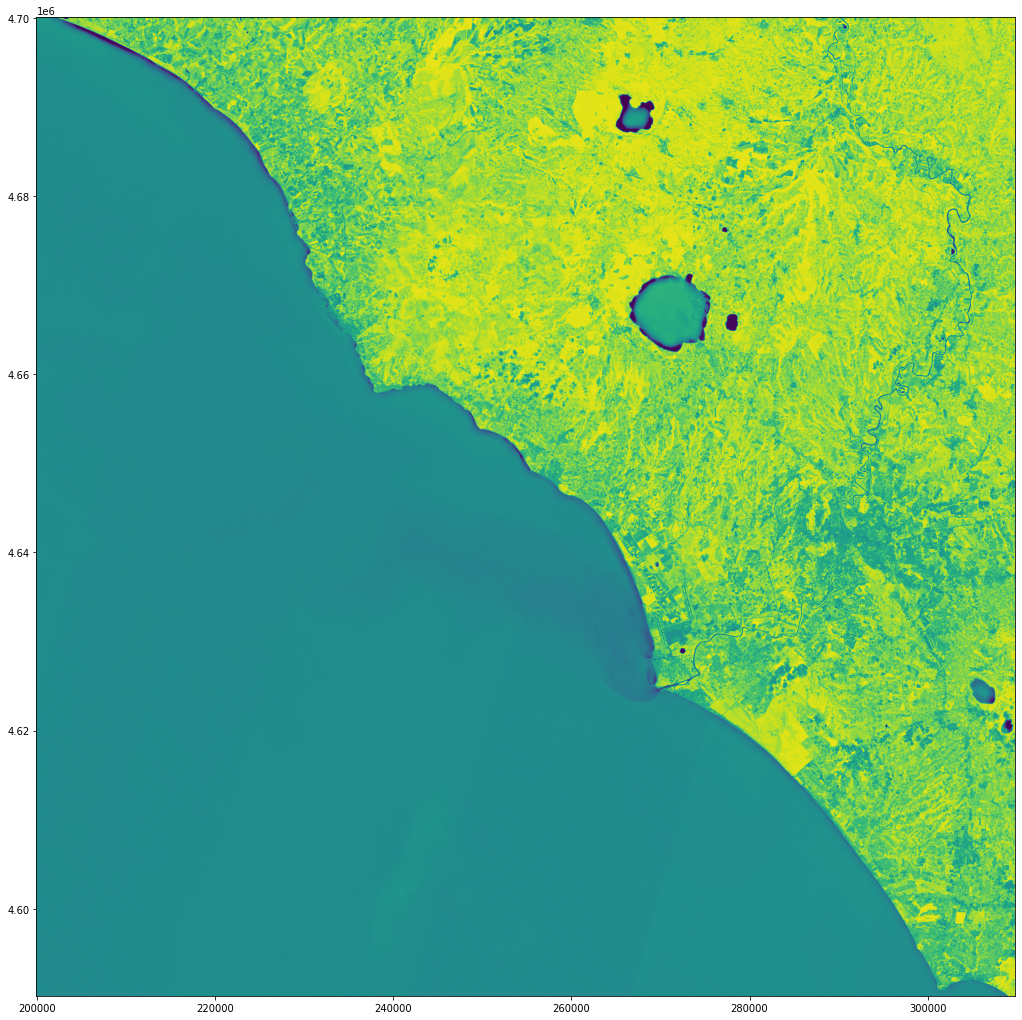

In [37]:
msk = rio.open("NDVI.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk,ax=ax)
plt.show